## Importing the relevant packages


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima_model import ARMA
from scipy.stats.distributions import chi2
import statsmodels.tsa.stattools as sts 
import seaborn as sns
sns.set()

In [2]:
#Se utiliza para suprimir las advertencias (warnings) que se generan durante la ejecución de un programa de Python.
import warnings
warnings.filterwarnings("ignore")

## Importing the Data and Pre-processing 

In [3]:
raw_csv_data = pd.read_csv("Index2023.csv") 
df_comp=raw_csv_data.copy()
df_comp.date = pd.to_datetime(df_comp.date, dayfirst = False)
df_comp.set_index("date", inplace=True)
df_comp=df_comp.asfreq('b')
df_comp=df_comp.fillna(method='ffill')

In [4]:
df_comp['market_value']=df_comp.ftse

In [5]:
del df_comp['spx']
del df_comp['dax']
del df_comp['ftse']
del df_comp['nikkei']
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

## LLR Test

In [17]:
#Realizar una prueba de razón de verosimilitud (LLR) entre dos modelos
def LLR_test(mod_1, mod_2, DF=1):
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF).round(4)
    return p

## The DF-Test

In [18]:
sts.adfuller(df.market_value)
#Ho = Raiz unitaria (No es estacionario)
#Ha = No hay raiz unitaria (Es estacionario)

(-1.6423364186571339,
 0.4610402085302002,
 6,
 6192,
 {'1%': -3.4314065266455214,
  '5%': -2.862006890314898,
  '10%': -2.567018522876271},
 67672.05153543489)

## Using Returns

In [19]:
#Calcula el cambio porcentual entre los valores sucesivos en la columna "market_value"
#mul(100): Multiplica el resultado por 100 para expresar la tasa de rendimiento en términos porcentuales. 
df['returns'] = df.market_value.pct_change(1).mul(100)
df = df.iloc[1:] #Utiliza para eliminar la primera fila del DataFrame 

In [20]:
sts.adfuller(df.returns)
#Ho = Raiz unitaria (No es estacionario)
#Ha = No hay raiz unitaria (Es estacionario)

(-15.001976187602006,
 1.0864669356473613e-27,
 34,
 6163,
 {'1%': -3.4314115002052303,
  '5%': -2.862009087791214,
  '10%': -2.567019692647172},
 18853.01379818433)

## ACF and PACF for Returns

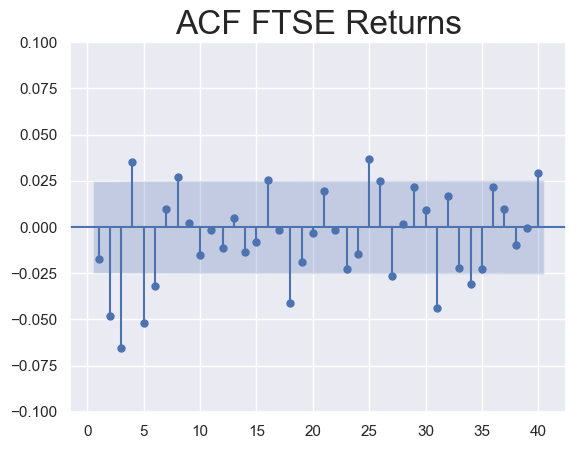

In [21]:
#Gráfico de la función de autocorrelación (ACF)
sgt.plot_acf(df.returns, lags=40, zero = False)
plt.title("ACF FTSE Returns", size=24)
plt.ylim(-0.1, 0.1) #Limitar el eje y 
plt.show()

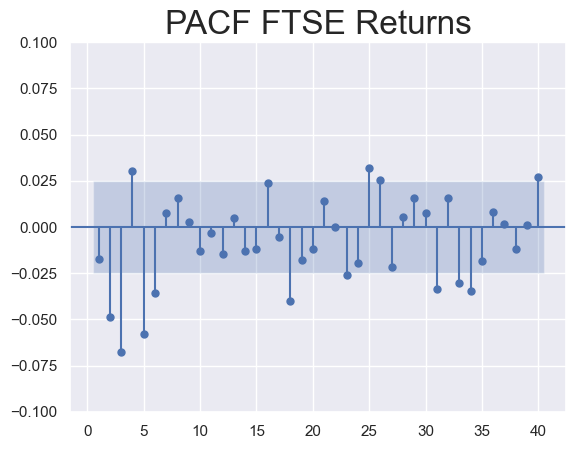

In [22]:
#Grafico de funcion de autocorrelacion parcial (PACF)
sgt.plot_pacf(df.returns, lags = 40, zero = False, method = ('ols')) #Metodo de MCO
plt.title("PACF FTSE Returns", size=24)
plt.ylim(-0.1, 0.1) #Limitar el eje y 
plt.show()

## AR(1) for Returns

In [23]:
#En versiones recientes de StatsModels, la clase ARMA se ha eliminado y se recomienda utilizar SARIMAX incluso para modelos ARMA.
#Aquí tienes un ejemplo actualizado de cómo ajustar un modelo ARMA utilizando SARIMAX
import statsmodels.api as sm
model_ret_ar_1 = sm.tsa.SARIMAX(df.returns, order = (1,0,0))

In [24]:
results_ret_ar_1 = model_ret_ar_1.fit()

In [25]:
results_ret_ar_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 6198
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -9511.658
Date:                Mon, 09 Oct 2023   AIC                          19027.316
Time:                        21:20:57   BIC                          19040.780
Sample:                    01-11-1994   HQIC                         19031.984
                         - 10-12-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0172      0.007     -2.300      0.021      -0.032      -0.003
sigma2         1.2603      0.011    112.051      0.000       1.238       1.282
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             10125.52
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.87   Skew:                            -0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Higher-Lag AR Models for Returns

In [26]:
model_ret_ar_2 = sm.tsa.SARIMAX(df.returns, order = (2,0,0))
results_ret_ar_2 = model_ret_ar_2.fit()
results_ret_ar_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 6198
Model:               SARIMAX(2, 0, 0)   Log Likelihood               -9504.434
Date:                Mon, 09 Oct 2023   AIC                          19014.869
Time:                        21:21:01   BIC                          19035.065
Sample:                    01-11-1994   HQIC                         19021.871
                         - 10-12-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0181      0.008     -2.385      0.017      -0.033      -0.003
ar.L2         -0.0482      0.007     -6.910      0.000      -0.062      -0.035
sigma2         1.2574      0.011    111.564      0.000       1.235       1.280
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):              9956.52
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               0.88   Skew:                            -0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [27]:
LLR_test(model_ret_ar_1, model_ret_ar_2)
#Rechazar la hipótesis nula
#El modelo alternativo (model_ret_ar_2) es preferible al modelo nulo (model_ret_ar_1) en función de la verosimilitud de los datos observados.

0.0001

In [28]:
model_ret_ar_3 = sm.tsa.SARIMAX(df.returns, order = (3,0,0))
results_ret_ar_3 = model_ret_ar_3.fit()
results_ret_ar_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 6198
Model:               SARIMAX(3, 0, 0)   Log Likelihood               -9490.362
Date:                Mon, 09 Oct 2023   AIC                          18988.724
Time:                        21:25:55   BIC                          19015.652
Sample:                    01-11-1994   HQIC                         18998.060
                         - 10-12-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0213      0.008     -2.768      0.006      -0.036      -0.006
ar.L2         -0.0495      0.007     -7.123      0.000      -0.063      -0.036
ar.L3         -0.0673      0.007     -9.630      0.000      -0.081      -0.054
sigma2         1.2517      0.012    106.754      0.000       1.229       1.275
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              9010.17
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               0.88   Skew:                            -0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
LLR_test(model_ret_ar_2, model_ret_ar_3)
#Rechazar la hipótesis nula
#El modelo alternativo (model_ret_ar_3) es preferible al modelo nulo (model_ret_ar_2) en función de la verosimilitud de los datos observados.

0.0

In [30]:
model_ret_ar_4 = sm.tsa.SARIMAX(df.returns, order = (4,0,0))
results_ret_ar_4 = model_ret_ar_4.fit()
print(results_ret_ar_4.summary())
print ("LLR test: " + str(LLR_test(model_ret_ar_3, model_ret_ar_4)))

#Rechazar la hipótesis nula
#El modelo alternativo (model_ret_ar_4) es preferible al modelo nulo (model_ret_ar_3) en función de la verosimilitud de los datos observados.

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 6198
Model:               SARIMAX(4, 0, 0)   Log Likelihood               -9487.480
Date:                Mon, 09 Oct 2023   AIC                          18984.961
Time:                        21:26:06   BIC                          19018.621
Sample:                    01-11-1994   HQIC                         18996.631
                         - 10-12-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0193      0.008     -2.494      0.013      -0.034      -0.004
ar.L2         -0.0480      0.007     -6.875      0.000      -0.062      -0.034
ar.L3         -0.0666      0.007     -9.514      0.0

In [31]:
model_ret_ar_5 = sm.tsa.SARIMAX(df.returns, order = (5,0,0))
results_ret_ar_5 = model_ret_ar_5.fit()
print(results_ret_ar_5.summary())
print ("LLR test: " + str(LLR_test(model_ret_ar_4, model_ret_ar_5)))

#Rechazar la hipótesis nula
#El modelo alternativo (model_ret_ar_5) es preferible al modelo nulo (model_ret_ar_4) en función de la verosimilitud de los datos observados.

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 6198
Model:               SARIMAX(5, 0, 0)   Log Likelihood               -9477.275
Date:                Mon, 09 Oct 2023   AIC                          18966.549
Time:                        21:26:19   BIC                          19006.941
Sample:                    01-11-1994   HQIC                         18980.553
                         - 10-12-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0175      0.008     -2.207      0.027      -0.033      -0.002
ar.L2         -0.0518      0.007     -7.337      0.000      -0.066      -0.038
ar.L3         -0.0694      0.007     -9.938      0.0

In [32]:
model_ret_ar_6 = sm.tsa.SARIMAX(df.returns, order = (6,0,0))
results_ret_ar_6 = model_ret_ar_6.fit()
print(results_ret_ar_6.summary())
print ("LLR test: " + str(LLR_test(model_ret_ar_5, model_ret_ar_6)))

#Rechazar la hipótesis nula
#El modelo alternativo (model_ret_ar_6) es preferible al modelo nulo (model_ret_ar_5) en función de la verosimilitud de los datos observados.

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 6198
Model:               SARIMAX(6, 0, 0)   Log Likelihood               -9473.383
Date:                Mon, 09 Oct 2023   AIC                          18960.767
Time:                        21:26:28   BIC                          19007.891
Sample:                    01-11-1994   HQIC                         18977.105
                         - 10-12-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0195      0.008     -2.419      0.016      -0.035      -0.004
ar.L2         -0.0507      0.007     -7.118      0.000      -0.065      -0.037
ar.L3         -0.0718      0.007    -10.268      0.0

In [33]:
model_ret_ar_7 = sm.tsa.SARIMAX(df.returns, order = (7,0,0))
results_ret_ar_7 = model_ret_ar_7.fit()
results_ret_ar_7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 6198
Model:               SARIMAX(7, 0, 0)   Log Likelihood               -9473.182
Date:                Mon, 09 Oct 2023   AIC                          18962.365
Time:                        21:26:36   BIC                          19016.221
Sample:                    01-11-1994   HQIC                         18981.037
                         - 10-12-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0193      0.008     -2.376      0.017      -0.035      -0.003
ar.L2         -0.0503      0.007     -7.009      0.000      -0.064      -0.036
ar.L3         -0.0721      0.007    -10.131      0.000      -0.086      -0.058
ar.L4          0.0281      0.007      3.796      0.000       0.014       0.043
ar.L5         -0.0575      0.007     -8.056      0.000      -0.072      -0.044
ar.L6         -0.0353      0.008     -4.463      0.000      -0.051      -0.020
ar.L7          0.0081      0.008      1.006      0.315      -0.008       0.024
sigma2         1.2448      0.012    103.814      0.000       1.221       1.268
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              8518.10
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.89   Skew:                            -0.18
Prob(H) (two-sided):                  0.01   Kurtosis:                         8.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [34]:
print (LLR_test(model_ret_ar_6, model_ret_ar_7))

#No hay evidencia estadística para rechazar la hipótesis nula
#Ambos modelos (model_ret_ar_7 y model_ret_ar_6) tienen un rendimiento similar en términos de ajuste a los datos observados 
#y que no hay suficiente evidencia para preferir uno sobre el otro en función de la verosimilitud

0.5261


## Normalizing Values

In [35]:
benchmark = df.market_value.iloc[0] #Asigna el valor del primer elemento de la columna "market_value"

In [36]:
#div(benchmark): Divide cada valor en la columna "market_value" por el valor de referencia benchmark
df['norm'] = df.market_value.div(benchmark).mul(100)

In [37]:
sts.adfuller(df.norm)
#Ho = Raiz unitaria (No es estacionario)
#Ha = No hay raiz unitaria (Es estacionario)

(-1.628187321746295,
 0.46843968323244367,
 6,
 6191,
 {'1%': -3.431406697371607,
  '5%': -2.8620069657471543,
  '10%': -2.567018563030713},
 24145.799773012433)

In [38]:
bench_ret = df.returns.iloc[0] #Asigna el valor del primer elemento de la columna returns
df['norm_ret'] = df.returns.div(bench_ret).mul(100)
sts.adfuller(df.norm_ret)
#Ho = Raiz unitaria (No es estacionario)
#Ha = No hay raiz unitaria (Es estacionario)

(-15.001976187602052,
 1.0864669356472135e-27,
 34,
 6163,
 {'1%': -3.4314115002052303,
  '5%': -2.862009087791214,
  '10%': -2.567019692647172},
 78695.73475393423)

## Normalized Returns

In [39]:
#En versiones recientes de StatsModels, la clase ARMA se ha eliminado y se recomienda utilizar SARIMAX incluso para modelos ARMA.
#Aquí tienes un ejemplo actualizado de cómo ajustar un modelo ARMA utilizando SARIMAX
import statsmodels.api as sm

model_norm_ret_ar_1 = sm.tsa.SARIMAX(df.norm_ret, order=(1,0,0))
results_norm_ret_ar_1 = model_norm_ret_ar_1.fit()
results_norm_ret_ar_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               norm_ret   No. Observations:                 6198
Model:               SARIMAX(1, 0, 0)   Log Likelihood              -39602.944
Date:                Mon, 09 Oct 2023   AIC                          79209.887
Time:                        21:27:13   BIC                          79223.351
Sample:                    01-11-1994   HQIC                         79214.555
                         - 10-12-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0172      0.007     -2.301      0.021      -0.032      -0.003
sigma2      2.077e+04    185.420    112.039      0.000    2.04e+04    2.11e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             10125.48
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.87   Skew:                             0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [40]:
model_norm_ret_ar_2 = sm.tsa.SARIMAX(df.norm_ret, order=(2,0,0))
results_norm_ret_ar_2 = model_norm_ret_ar_2.fit()
results_norm_ret_ar_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               norm_ret   No. Observations:                 6198
Model:               SARIMAX(2, 0, 0)   Log Likelihood              -39595.720
Date:                Mon, 09 Oct 2023   AIC                          79197.440
Time:                        21:27:17   BIC                          79217.636
Sample:                    01-11-1994   HQIC                         79204.442
                         - 10-12-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0181      0.008     -2.385      0.017      -0.033      -0.003
ar.L2         -0.0482      0.007     -6.910      0.000      -0.062      -0.035
sigma2      2.073e+04    185.780    111.558      0.000    2.04e+04    2.11e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):              9956.53
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               0.88   Skew:                             0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [41]:
model_norm_ret_ar_7 = sm.tsa.SARIMAX(df.norm_ret, order=(7,0,0))
results_norm_ret_ar_7 = model_norm_ret_ar_7.fit()
results_norm_ret_ar_7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               norm_ret   No. Observations:                 6198
Model:               SARIMAX(7, 0, 0)   Log Likelihood              -39564.468
Date:                Mon, 09 Oct 2023   AIC                          79144.936
Time:                        21:27:21   BIC                          79198.792
Sample:                    01-11-1994   HQIC                         79163.608
                         - 10-12-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0193      0.008     -2.376      0.017      -0.035      -0.003
ar.L2         -0.0503      0.007     -7.007      0.000      -0.064      -0.036
ar.L3         -0.0721      0.007    -10.127      0.000      -0.086      -0.058
ar.L4          0.0281      0.007      3.793      0.000       0.014       0.043
ar.L5         -0.0575      0.007     -8.053      0.000      -0.072      -0.044
ar.L6         -0.0353      0.008     -4.461      0.000      -0.051      -0.020
ar.L7          0.0081      0.008      1.005      0.315      -0.008       0.024
sigma2      2.052e+04    197.788    103.770      0.000    2.01e+04    2.09e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              8518.09
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.89   Skew:                             0.18
Prob(H) (two-sided):                  0.01   Kurtosis:                         8.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Analysing the Residuals

In [42]:
#Agregando una nueva columna llamada "res_ret" al df. Esta columna contendrá los residuos del modelo results_ret_ar_6, 
#que son las diferencias entre los valores reales de la serie temporal y las predicciones del modelo.
df['res_ret'] = results_ret_ar_6.resid 

In [43]:
df.res_ret.mean() #Calcula la media de los valores en la columna res_ret

0.022932838705116452

In [44]:
df.res_ret.var() #Calcula la varianza de los valores en la columna res_ret

1.2445513563654755

In [45]:
sts.adfuller(df.res_ret)
#Ho = Raiz unitaria (No es estacionario)
#Ha = No hay raiz unitaria (Es estacionario)

(-14.857712257951645,
 1.73813207436845e-27,
 34,
 6163,
 {'1%': -3.4314115002052303,
  '5%': -2.862009087791214,
  '10%': -2.567019692647172},
 18854.684848937464)

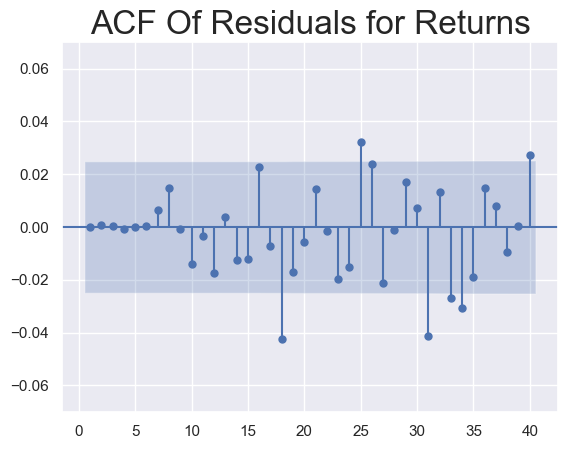

In [46]:
#Calculará la ACF
#zero=False: Utiliza para excluir el retraso cero en el gráfico de ACF
#lags=40: Determina hasta qué retraso se calculará la ACF y se mostrará en el gráfica
sgt.plot_acf(df.res_ret, zero = False, lags = 40)
plt.title("ACF Of Residuals for Returns",size=24)
plt.ylim(-0.07,0.07)
plt.show()

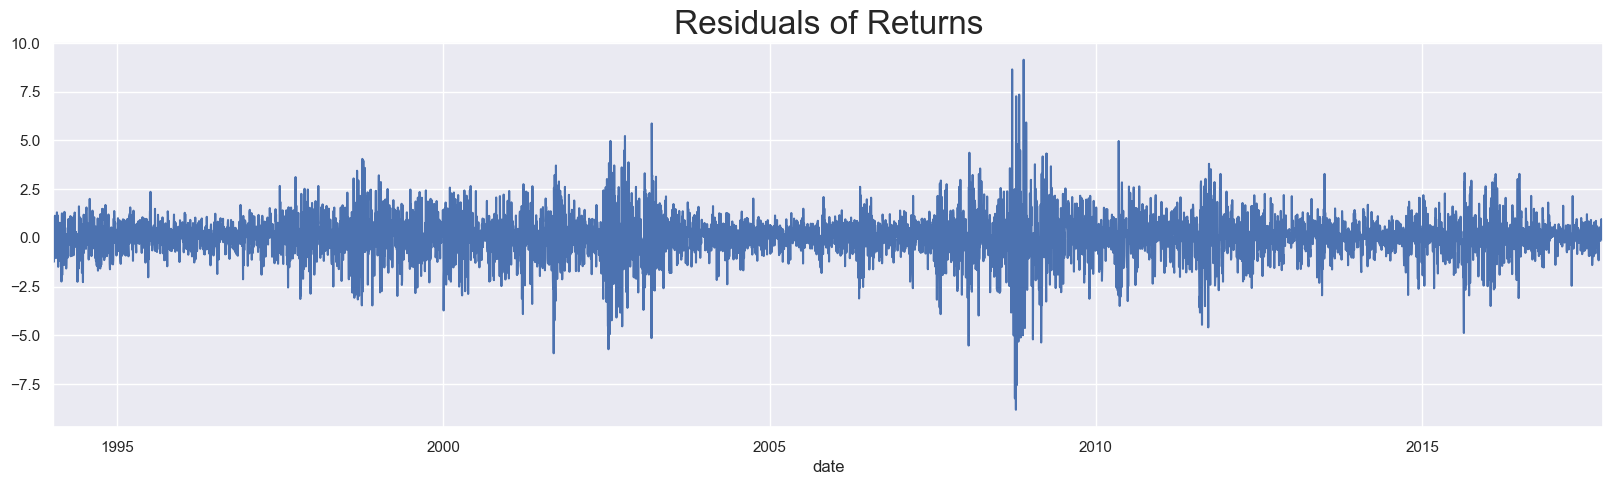

In [47]:
#Gráfico de la serie de tiempo de los residuos
#[1:] se utiliza para excluir el primer valor de los residuos
df.res_ret.plot(figsize=(20,5))
plt.title("Residuals of Returns", size=24)
plt.show()